In [356]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate, PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from typing import List, Dict, Any
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import PydanticOutputParser
import os
from dotenv import load_dotenv
# from langchain.document_loaders import PyMuPDFLoader
from typing import List, Dict, Any, Optional
import fitz
from pydantic import BaseModel, Field
load_dotenv()

True

In [357]:
os.environ["LANGSMITH_PROJECT"] = f"MineD 2025"

In [358]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [360]:
# llm = ChatGroq(model="gemma2-9b-it")

## LangGraph Agent

### Graph State and Data Models

In [ ]:
# Define Pydantic Model for PPT slides
class SlideContent(BaseModel):
    title: str = Field(..., description="Title of the particular slide")
    bullet_points: Optional[List[str]] = Field(None, description="Content in bullet points form for the slide")
    notes: Optional[str] = Field(None, description="Additional notes for the slide")
    images: Optional[List[str]] = Field(None, description="List of relevant image paths for the slide")

class PPTPresentation(BaseModel):
    title: str = Field(..., description="Title of the presentation")
    authors: List[str] = Field(..., description="List of authors of the presentation")
    institution: str = Field(..., description="Institution associated with the presentation")
    slides: List[SlideContent] = Field(..., description="List of slides, in the presentation,which are SlideContent schemas.")

class Dialogue(BaseModel):
    text: str = Field(..., description="The text of dialogue")

class Conversation(BaseModel):
    katherine: List[Dialogue] = Field(..., description="Katherine's dialogues")
    clay: List[Dialogue] = Field(..., description="Clay's dialogues")
    order: List[str] = Field(..., description="The order of dialogues denoted by the names of the speaker")

class ResPaperExtractState(TypedDict):
    pdf_path: Optional[str] = None  # Path to the PDF file
    extracted_text: Optional[str] = None  # Full extracted text from the PDF
    extracted_images: Optional[Dict[str,str]] = None  # Paths to extracted images
    slides_content: Optional[List[Dict[str, str]]] = None  # Prepared content for PowerPoint slides
    ppt_object: PPTPresentation
    summary_text: str
    convo: Conversation


### Extracting Text from PDF

In [ ]:
def load_pdf(state: ResPaperExtractState):
    pdf_path = state["pdf_path"]
    doc = fitz.open(pdf_path)  # Load the PDF only once
    
    extracted_text = []
    extracted_images = dict()
    output_folder = "extracted_images"
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through each page
    img_cntr=1
    for page_number, page in enumerate(doc):
        # Extract text
        text = page.get_text("text")
        extracted_text.append(text)

        # Extract images
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]
            img_filename = f"{output_folder}/page_{page_number+1}_img_{img_index+1}.{image_ext}"
            
            with open(img_filename, "wb") as img_file:
                img_file.write(image_bytes)
            
            extracted_images[f"Fig{img_cntr}"] = img_filename
            img_cntr+=1

    # Combine text from all pages
    full_text = "\n".join(extracted_text)

    # Update state
    return {"extracted_text": full_text, "extracted_images": extracted_images}

### PPT Content Generation

In [ ]:
import re
def clean_markdown_output(llm_out: str) -> str:
    # Remove leading and trailing triple backticks if present
    if not isinstance(llm_out, str):
        llm_out = str(llm_out.content)  # Extract string content from AIMessage
    return re.sub(r"^```(?:json)?\n?|```$", "", llm_out.strip())

In [368]:
system_message = SystemMessagePromptTemplate.from_template(
    """You are an expert in creating PowerPoint presentations. Generate a structured PowerPoint (PPT) presentation 
    that summarizes a research paper based on the provided extracted text. Follow these instructions:
    
    Remember that the objective of this PPT is for a third party to understand the key points of the research paper, and 
    give them a gist of the research paper.

    - Title Slide: Include the research paper title, authors, and institution.
    - Introduction Slide: Summarize the problem, objectives, and motivation.
    - Methods Slide: Briefly explain the methodology, datasets, and experimental setup.
    - Results Slide: Summarize key findings with bullet points. Mention any visuals (graphs, tables) found from the extracted text. You should definetly mention in the presentation any figures related to a performance metric or tables that are mentioned in the extracted text.
    - Graphics: Include any images of graphs or charts or other images, relevant to the results,or images depicting a performance metric,
      that are mentioned in the extracted text. You can find such images by looking for any captions that mention figures or tables. 
      It is necessary to name this slide as Graphics.
      Note that you should only strictly mention the image number, like Fig1, Fig2, etc...
      Include only relevant image names. 
    Discussion Slide: Explain the significance of results and compare with prior work.
    - Conclusion Slide: Summarize key takeaways and potential future work.
    - References Slide: Include citations if available.

    Additional Guidelines:
    - Keep slides concise (use bullet points).
    - Maintain a professional and visually appealing slide design.
    - Give the text in markdown format.
    - Each slide should have rich information content, summarizing the information related to the particular slide heading, 

    Do not format the output in markdown, do not use triple backticks (` ``` `) or JSON code blocks.
    Ensure that the response is a valid JSON object that follows the expected schema.
    {format_instructions}
    """
)

# Human Message: Supplies extracted text from the research paper
human_message = HumanMessagePromptTemplate.from_template("Here is the extracted text:\n\n{extracted_text}")

parser = JsonOutputParser(pydantic_object=PPTPresentation)
# Combine into a structured chat prompt
chat_prompt = ChatPromptTemplate(
    messages=[system_message, human_message],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

def get_data(state):
    extracted_text = state["extracted_text"]
    
    # Format prompt with extracted text
    prompt = chat_prompt.invoke({"extracted_text": extracted_text})
    # Invoke LLM with structured output
    llm_out = llm.invoke(prompt)
    cleaned_llm_out = clean_markdown_output(llm_out)
    parsed = parser.invoke(cleaned_llm_out)

    # Parse structured output into Pydantic model
    # ppt_object = chain.invoke({"extracted_text":extracted_text})
    
    return {"ppt_object": parsed}

### Summary for Podcast

In [369]:
def generate_summary(state: ResPaperExtractState):
    extracted_text = state["extracted_text"]

    summary_template_string_2 = """
        You are an expert science communicator who specializes in breaking down complex research papers into engaging, conversational summaries. Your goal is to generate a summary that will be used to generate text for conversational podcast.
        The summary should be structured in a way that makes it engaging for a podcast discussion. 
        Include thought-provoking questions and key discussion points that make the findings compelling to a general audience.

        ### **Instructions:**
        - Start with an **intriguing hook** that captures the essence of the paper in an engaging way. 
        - Clearly state the **research problem** and why it matters.
        - Summarize the **key findings** and their implications, but in a way that sparks curiosity.
        - **Use an engaging tone** that makes it feel like a conversation rather than a dry summary.
        - Include at least **three discussion-worthy questions** that podcast hosts could debate.
        - Highlight any **visual elements** that could be useful for a graphical abstract, such as relationships between variables, experimental results, or unexpected insights.

        ### **Important Guidelines:**
        - Keep it insightful yet engaging—avoid overly technical jargon unless necessary.  
        - Don’t make the summary too short; ensure all important elements of the research are covered.  
        - Aim for a summary length of **300-500 words** to balance depth with readability.  
        - If applicable, include **real-world analogies** or examples to make the findings more relatable. 
        - Remember, the goal is to make the research accessible and interesting to a broad audience.
        - Return a single string with the summary text, acheiving the above objectives. 
        -Do not format the output in markdown, do not use triple backticks (` ``` `) or JSON code blocks.
        Ensure that the response is a valid JSON object that follows the expected schema.
        Now, using these guidelines, generate a well-structured summary of the following research paper: {text}  

    """
    summary_prompt = PromptTemplate.from_template(summary_template_string_2)
    # Generate summary with LLM
    summary_text = llm.invoke(summary_prompt.format(text=extracted_text))  # No chunking, single LLM call
    
    return {"summary_text": summary_text}

### Podcast Transcript

In [370]:
system_message_podcast = SystemMessagePromptTemplate.from_template(
    """You are an expert in creating/writing scripts for podcasts. 
    Consider the given scenario: Two people one girl and one boy who are in final year of their B.Tech, are discussing the given research paper to create an podcast of this research paper
    
    Boy's Name: Clay
    Girl's Name: Katherine
    
    The Girl has complete knowledge about this paper, while the boy doesn't know anything about the paper.
    
    Write a script for a podcast, wherein firstly the girl introduces the paper, but the boy seems clueless.So the boy ask the girl many questions about the paper, to understand the paper and learn more about the keyowrds and topics involved.
    
    The boy's question should cover all the possible doubt that one can have regarding the paper, and the girl should answer that questions correctly.

    General Guideline:
    - Intro must include the name, application and the authors (and their institution)
    - Consider the audience to be technically sound, so you can ue jargons
    - The boys questions should cover all the aspects from methodology, results, literature review, etc
    - Dont make it too obvious that they are discussing about the paper
    - Make the order such that the question asked by clay in previous dialogue is answered by katherine in this dialogue.

    Additional Guidelines:
    - Consider that the girl always starts first
    - Also give the order of dialogues, that are to be taken in a sequence
    - Make sure that the number of dialogues in the order and in the lists add up.
    - Both of them dont have to speak alternatively, they can heave continuous dialogues
    - Each and every question asked by clay has to be answered by katherine
    - Make sure that the both the persons are not inventing anything of their own, nor should they give any wrong information.
    - Don't give a name to this podcast
    - If a particular entity or its name can't be inferred, don't mention them as placeholders in the conversation
    - Do not format the output in markdown, do not use triple backticks (` ``` `) or JSON code blocks.
    Ensure that the response is a valid JSON object that follows the expected schema.
    {format_instructions}
    """
)

# Human Message: Supplies extracted text from the research paper
human_message_podcast = HumanMessagePromptTemplate.from_template("Here is the summary of research paper:\n\n{summary_text}. \nMake sure the tone is {tone}")

parser_podcast = JsonOutputParser(pydantic_object=Conversation)
# Combine into a structured chat prompt
chat_prompt_podcast = ChatPromptTemplate(
    messages=[system_message_podcast, human_message_podcast],
    partial_variables={"format_instructions": parser_podcast.get_format_instructions()}
)

def generate_conversation(state: ResPaperExtractState):
    summary_text = state["summary_text"]
    prompt = chat_prompt_podcast.invoke({"summary_text": summary_text, "tone": "informative"})
    # llm_out = llm.invoke(prompt)
    # parsed = parser_podcast.invoke(llm_out)
    llm_out = llm.invoke(prompt)
    cleaned_llm_out = clean_markdown_output(llm_out)
    parsed = parser.invoke(cleaned_llm_out)

    
    return {"convo":parsed}



### Prompt Experimentation

In [ ]:
"""
Here’s the textual representation of your PowerPoint template, structured for easy LLM integration:  

---

### **Slide 1: Title Slide**  
- **Title:** Research Presentation Title  
- **Subtitle:** Subtitle / Tagline (Auto-generated by LLM)  

### **Slide 2: Introduction (Hook)**  
- **Title:** Introduction: Why Does This Matter?  
- **Content:**  
  - Hook or problem statement  
  - Engaging question  
  - Real-world relevance  

### **Slide 3: Research Summary**  
- **Title:** Research Summary  
- **Content:**  
  - Key findings  
  - Core methodology  
  - Main contributions  

### **Slide 4: Data & Insights (Visual Representation)**  
- **Title:** Data & Insights (Visual)  
- **Left Content:** Placeholder for Graph / Infographic (Generated by LLM)  
- **Right Content:** Key explanation points  

### **Slide 5: Making It Fun! (Meme / Pop Culture Connection)**  
- **Title:** Making It Fun!  
- **Content:**  
  - Meme / Analogy (LLM-generated)  
  - Relatable explanation  

### **Slide 6: Interactive Section (Quiz or Poll)**  
- **Title:** Quick Quiz!  
- **Content:**  
  - Question related to research  
  - Generate upto 5 thought-provoking questions based on the research paper to encourage discussion.

### **Slide 7: Key Takeaways**  
- **Title:** Key Takeaways  
- **Content:**  
  - Summary of main insights  
  - Impact and future work  

### **Slide 8: Thank You **
- **Title:** Thank You!  
- **Content:**  
  - QR Code to paper/resources (LLM-generated)  
  - Socials / Contact  
"""

'\nHere’s the textual representation of your PowerPoint template, structured for easy LLM integration:  \n\n---\n\n### **Slide 1: Title Slide**  \n- **Title:** Research Presentation Title  \n- **Subtitle:** Subtitle / Tagline (Auto-generated by LLM)  \n\n### **Slide 2: Introduction (Hook)**  \n- **Title:** Introduction: Why Does This Matter?  \n- **Content:**  \n  - Hook or problem statement  \n  - Engaging question  \n  - Real-world relevance  \n\n### **Slide 3: Research Summary**  \n- **Title:** Research Summary  \n- **Content:**  \n  - Key findings  \n  - Core methodology  \n  - Main contributions  \n\n### **Slide 4: Data & Insights (Visual Representation)**  \n- **Title:** Data & Insights (Visual)  \n- **Left Content:** Placeholder for Graph / Infographic (Generated by LLM)  \n- **Right Content:** Key explanation points  \n\n### **Slide 5: Making It Fun! (Meme / Pop Culture Connection)**  \n- **Title:** Making It Fun!  \n- **Content:**  \n  - Meme / Analogy (LLM-generated)  \n  - R

In [ ]:
system_message_pptgen = SystemMessagePromptTemplate.from_template(
    """ 
🎬 Slide 1: Title & Hook

Big Bold Title with an eye-catching background.

Engaging Hook: Meme, GIF, or a thought-provoking question.

Subtitle: One-liner that teases the research topic (e.g., "Can AI Predict Traffic Before You Even Leave Home?").

Your Name & Affiliation

🧐 Slide 2: The Problem (Why Should We Care?)

Minimal Text: Use an infographic or a relatable image.

Example/Scenario: "Imagine being stuck in traffic for hours... what if we could fix that?" (for AI traffic research).

Poll or Audience Interaction: Quick question like "How often do you check Google Maps before heading out?" (Slido, Kahoot, PowerPoint live polls).

🔬 Slide 3: Research Overview (What’s Happening Here?)

Visual Summary: Flowchart, concept map, or a simple animated diagram.

One-Sentence Explanation of the research goal.

A Fun Analogy: "Think of this model like Netflix recommendations, but for predicting traffic jams."

🏗️ Slide 4: Methodology (How We Did It)

Minimal Bullet Points: (3 key steps max).

Diagram or Icons: Instead of heavy text.

Short Video/Animation (if applicable).

QR Code: Link to GitHub repo or dataset.

📊 Slide 5: Key Findings (What Did We Discover?)

Graph/Infographic Instead of Text.

Keep it Digestible: 2-3 major insights with emoji-based emphasis (e.g., 📉 Lower Traffic, 🚀 Faster Commute).
A Surprising Fact: "Did you know X% of delays could be avoided with predictive AI?"

🌍 Slide 6: Real-World Applications (Why It Matters)
Real-World Example.
Comparison Chart: "What happens with vs. without this research?".
Quote from an Expert or Impact Statement.

🔮 Slide 7: Future Scope (What’s Next?)
Mind-Blowing Prediction: "Could this tech be used in self-driving cars?".
Audience Involvement: "What would YOU improve? Drop your ideas!".

🎤 Slide 8: Q&A
Generate a set of thought-provoking questions based on the research paper to encourage discussion.
"""
)

### Graph Builder

In [371]:

builder = StateGraph(ResPaperExtractState)

builder.add_node("pdf-2-text", load_pdf)
builder.add_node("ppt-extract", get_data)
builder.add_node("summary-text", generate_summary)
builder.add_node("conversation", generate_conversation)

builder.add_edge(START, "pdf-2-text")
builder.add_edge("pdf-2-text", "ppt-extract")
builder.add_edge("pdf-2-text", "summary-text")
builder.add_edge("summary-text", "conversation")
builder.add_edge("ppt-extract", END)
builder.add_edge("conversation", END)
graph = builder.compile()


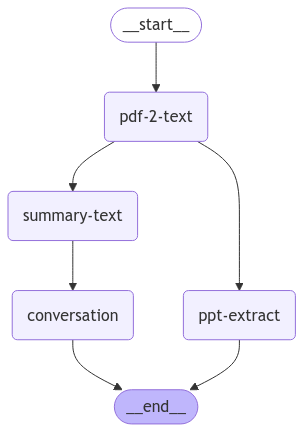

In [384]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
path = r"agents\uploaded_pdfs\Attention Is All You Need.pdf"
state_output = graph.invoke({"pdf_path":path})

In [373]:
state_output["extracted_text"]

'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence

In [374]:
type(state_output["summary_text"].content)

str

In [375]:
type(state_output["convo"])

dict

In [376]:
type(state_output["ppt_object"])

dict

## PPT Generation

In [377]:
ppt_content = state_output["ppt_object"]
# print(ppt_content)
print(ppt_content["slides"][1])

{'title': 'Introduction', 'bullet_points': ['Problem: Existing sequence transduction models (RNNs, CNNs) are inherently sequential, limiting parallelization and training speed.', 'Objectives: Propose a new architecture, the Transformer, based solely on attention mechanisms.', 'Motivation: Achieve superior translation quality with increased parallelization and faster training.'], 'notes': None, 'images': None}


In [378]:
list(state_output["extracted_images"].values())

['extracted_images/page_3_img_1.png',
 'extracted_images/page_4_img_1.png',
 'extracted_images/page_4_img_2.png']

In [379]:
for key,value in state_output["extracted_images"].items():
    print(key,value)

Fig1 extracted_images/page_3_img_1.png
Fig2 extracted_images/page_4_img_1.png
Fig3 extracted_images/page_4_img_2.png


In [380]:
os.path.exists('extracted_images/page_1_img_1.jpeg')

True

In [381]:
ppt_content["slides"]

[{'title': 'Title Slide',
  'bullet_points': ['Attention Is All You Need',
   'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin',
   'Google Brain, Google Research, University of Toronto'],
  'notes': None,
  'images': None},
 {'title': 'Introduction',
  'bullet_points': ['Problem: Existing sequence transduction models (RNNs, CNNs) are inherently sequential, limiting parallelization and training speed.',
   'Objectives: Propose a new architecture, the Transformer, based solely on attention mechanisms.',
   'Motivation: Achieve superior translation quality with increased parallelization and faster training.'],
  'notes': None,
  'images': None},
 {'title': 'Methods',
  'bullet_points': ['Methodology: Transformer architecture based entirely on self-attention mechanisms.',
   'Datasets: WMT 2014 English-German and English-French translation tasks, Penn Treebank for English constituency parsing.',
   'Experimental Setu

In [382]:
from pptx import Presentation
from pptx.util import Pt, Inches
from pptx.enum.text import PP_ALIGN, MSO_ANCHOR, MSO_AUTO_SIZE
from pptx.dml.color import RGBColor

class ThemeConfig:
    def __init__(self, name="modern"):
        themes = {
            "modern": {
                "background": RGBColor(30, 30, 30),  # Dark gray background
                "title": RGBColor(255, 215, 0),  # Gold title text
                "body": RGBColor(200, 200, 200),  # Light gray body text
                "title_font": "Montserrat",
                "body_font": "Lato",
            },
            "vintage": {
                "background": RGBColor(245, 222, 179),  # Wheat background
                "title": RGBColor(139, 69, 19),  # Saddle brown title
                "body": RGBColor(105, 105, 105),  # Dim gray text
                "title_font": "Georgia",
                "body_font": "Times New Roman",
            },
            "corporate": {
                "background": RGBColor(255, 255, 255),  # White background
                "title": RGBColor(0, 51, 102),  # Navy blue title
                "body": RGBColor(51, 51, 51),  # Dark gray body text
                "title_font": "Arial",
                "body_font": "Verdana",
            },
            "minimal": {
                "background": RGBColor(240, 240, 240),  # Light gray background
                "title": RGBColor(50, 50, 50),  # Dark gray title
                "body": RGBColor(80, 80, 80),  # Slightly lighter gray for body
                "title_font": "Helvetica",
                "body_font": "Sans-Serif",
            },
            "bold": {
                "background": RGBColor(0, 0, 0),  # Black background
                "title": RGBColor(255, 0, 0),  # Red title text
                "body": RGBColor(255, 255, 255),  # White body text
                "title_font": "Impact",
                "body_font": "Arial Black",
            }
        }
        self.theme = themes.get(name, themes["minimal"])

def apply_background(slide, color):
    """Apply background color to a slide"""
    background = slide.background
    fill = background.fill
    fill.solid()
    fill.fore_color.rgb = color

def create_ppt_from_dict(ppt_data: dict, image_mapping: dict, theme_name: str="default", output_file: str = "presentation.pptx"):
    prs = Presentation()
    theme = ThemeConfig(theme_name)

    slide_width = prs.slide_width
    slide_height = prs.slide_height

    # Title Slide Fix
    title_slide_layout = prs.slide_layouts[0]  # Title slide layout
    title_slide = prs.slides.add_slide(title_slide_layout)
    apply_background(title_slide, theme.theme["background"])
    # Set title
    title = title_slide.shapes.title
    title.text = ppt_data['title']
    title_para = title.text_frame.paragraphs[0]
    title_para.font.size = Pt(40)
    title_para.font.name = theme.theme["title_font"]
    title_para.font.color.rgb = theme.theme["title"]
    title_para.alignment = PP_ALIGN.CENTER

    # Set subtitle (authors and institutions)
    subtitle = title_slide.placeholders[1]
    subtitle.text_frame.clear()  # Clear default placeholder text

    # Add authors as one paragraph
    authors_para = subtitle.text_frame.add_paragraph()
    authors_para.text = ", ".join(ppt_data['authors'])
    authors_para.font.size = Pt(18)
    authors_para.font.name = theme.theme["body_font"]
    authors_para.font.color.rgb = theme.theme["body"]
    authors_para.alignment = PP_ALIGN.CENTER

    # Add institution as a separate paragraph
    institution_para = subtitle.text_frame.add_paragraph()
    institution_para.text = "".join(ppt_data['institution'])
    institution_para.font.size = Pt(16)  # Slightly smaller font
    institution_para.font.name = theme.theme["body_font"]
    institution_para.font.color.rgb = theme.theme["body"]
    institution_para.alignment = PP_ALIGN.CENTER

    # Ensure the text fits within the shape
    subtitle.text_frame.auto_size = MSO_AUTO_SIZE.SHAPE_TO_FIT_TEXT
    subtitle.text_frame.word_wrap = True

    # Add content slides
    for i in range(1, len(ppt_data["slides"])):
        slide_data = ppt_data["slides"][i]
        title_text = slide_data.get("title", "")

        # Detect Graphics/Graphs Slide
        is_graphics_slide = "graphics" in title_text.lower() or "graphs slide" in title_text.lower()

        # Use a blank layout for Graphics slides
        slide_layout =  prs.slide_layouts[1]
        slide = prs.slides.add_slide(slide_layout)
        apply_background(slide, theme.theme["background"])

        if not is_graphics_slide:
            title = slide.shapes.title
            title.text = title_text
            title_para = title.text_frame.paragraphs[0]
            title_para.font.size = Pt(32)
            title_para.font.name = theme.theme["title_font"]
            title_para.font.color.rgb = theme.theme["title"]
        # Handling Graphics/Graphs Slide
        
        if is_graphics_slide and "images" in slide_data:
            image_filenames = slide_data["images"]
            image_paths = [image_mapping.get(fig.replace(".", "").replace(" ", "")) for fig in image_filenames]
            image_paths = [img for img in image_paths if img and os.path.exists(img)]  # Remove missing files
    
            num_images = len(image_paths)
    
            # Get theme colors
            caption_font = theme.theme["body_font"]
            caption_color = theme.theme["body"]
    
            # Define positioning based on number of images
            if num_images == 1:
                left, top, width, height = Inches(1.5), Inches(1.5), Inches(7), Inches(5)
                img_shape = slide.shapes.add_picture(image_paths[0], left, top, width=width, height=height)
                caption_left = left + width / 2 - Inches(0.5)
                caption_top = top + height + Inches(0.2)
    
                # Add caption
                caption = slide.shapes.add_textbox(caption_left, caption_top, Inches(1), Inches(0.5))
                text_frame = caption.text_frame
                text_frame.text = image_filenames[0]
                para = text_frame.paragraphs[0]
                para.font.size = Pt(14)
                para.font.name = caption_font
                para.font.color.rgb = caption_color
                para.alignment = PP_ALIGN.CENTER
    
            elif num_images == 2:
                positions = [(Inches(1), Inches(2)), (Inches(5.5), Inches(2))]
                size = (Inches(4), Inches(3))
    
                for i, img_path in enumerate(image_paths[:2]):
                    img_left, img_top = positions[i]
                    img_shape = slide.shapes.add_picture(img_path, img_left, img_top, *size)
    
                    # Add caption
                    caption_left = img_left + size[0] / 2 - Inches(0.5)
                    caption_top = img_top + size[1] + Inches(0.2)
                    caption = slide.shapes.add_textbox(caption_left, caption_top, Inches(1), Inches(0.5))
                    text_frame = caption.text_frame
                    text_frame.text = image_filenames[i]
                    para = text_frame.paragraphs[0]
                    para.font.size = Pt(14)
                    para.font.name = caption_font
                    para.font.color.rgb = caption_color
                    para.alignment = PP_ALIGN.CENTER
    
            elif num_images >= 3:
                positions = [
                    (Inches(1), Inches(1.5)), (Inches(5), Inches(1.5)),
                    (Inches(3), Inches(4))
                ]
                size = (Inches(3.5), Inches(2.5))
    
                for i, img_path in enumerate(image_paths[:3]):
                    img_left, img_top = positions[i]
                    img_shape = slide.shapes.add_picture(img_path, img_left, img_top, *size)
    
                    # Add caption
                    caption_left = img_left + size[0] / 2 - Inches(0.5)
                    caption_top = img_top + size[1] + Inches(0.2)
                    caption = slide.shapes.add_textbox(caption_left, caption_top, Inches(1), Inches(0.5))
                    text_frame = caption.text_frame
                    text_frame.text = image_filenames[i]
                    para = text_frame.paragraphs[0]
                    para.font.size = Pt(14)
                    para.font.name = caption_font
                    para.font.color.rgb = caption_color
                    para.alignment = PP_ALIGN.CENTER

        else: 
            bullet_points = slide_data.get("bullet_points", [])
            content_placeholder = slide.placeholders[1]
            text_frame = content_placeholder.text_frame
            text_frame.clear()
            if bullet_points:
                text_frame = content_placeholder.text_frame
                text_frame.clear()  # Remove default placeholder text
                text_frame.word_wrap = True  # Enable text wrapping
                text_frame.auto_size = MSO_AUTO_SIZE.SHAPE_TO_FIT_TEXT  # Enable auto size for content
                # Set default font size based on slide type
                is_references = "references" in slide_data.get("title", "").lower()
                DEFAULT_FONT_SIZE = 12 if is_references else 20
            for point in slide_data['bullet_points']:
                paragraph = text_frame.add_paragraph()
                paragraph.text = point
                paragraph.font.size = Pt(DEFAULT_FONT_SIZE)
                paragraph.font.name = theme.theme["body_font"]
                paragraph.font.color.rgb = theme.theme["body"]
                

    # Save PowerPoint file
    prs.save(output_file)
    print(f"PowerPoint presentation saved as {output_file}")

create_ppt_from_dict(ppt_content, state_output["extracted_images"], "modern", "static/new_one.pptx")

PowerPoint presentation saved as static/new_one.pptx


## TTS